In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [3]:
def synthetic_data(w,b,num_examples):
    """生成y=Xw+b+噪声"""
    # 首先生成nxd的原始输入（n代表样本的数量，d代表输入样本的维度）
    X = torch.normal(0,1,(num_examples,len(w)))
    # print(X,"\n",X.shape)
    # print((torch.matmul(X,w)).shape)
    # 其次计算y=Xw+b，注意linear regression输入一个样本输出的是一个scalar
    y = torch.matmul(X,w)+b
    # print(y,'\n',y.shape)
    # 对输出加高斯噪声，模拟数据集
    y += torch.normal(0,0.01,y.shape)
    # 最后把制造的特征和label输出
    # 注意，这里对y reshape是把原始一维的tensor变成二维，形成一个标准的列向量
    # 理解上看是为了好做矩阵运算？
    return X,y.reshape((-1,1))

In [4]:
# 模型真值
true_w = torch.tensor([2,-3.4])
true_b = 4.2
# 根据模型真值随机生成一些样本，并生成labels，不过因为是regression，不能所有的y都在线上，所以加了噪声，无偏估计，sigma值是0.01
features,labels = synthetic_data(true_w,true_b,1000)
print(labels,'\n',labels.shape)
print(features,'\n',features.shape)

tensor([[10.0380],
        [-1.4110],
        [ 4.8944],
        [-2.0649],
        [ 3.0696],
        [ 1.9956],
        [ 7.9800],
        [ 2.2065],
        [ 5.3455],
        [ 4.8763],
        [ 4.9626],
        [ 7.2398],
        [ 0.8628],
        [ 3.4961],
        [ 7.1758],
        [ 8.9669],
        [ 2.0479],
        [ 4.8452],
        [ 5.3999],
        [ 0.9143],
        [-2.1589],
        [ 0.0908],
        [ 0.2535],
        [ 7.0020],
        [ 7.9118],
        [ 3.6052],
        [ 6.7958],
        [ 6.9971],
        [ 7.6753],
        [ 6.5204],
        [-0.7488],
        [ 8.8908],
        [ 9.8511],
        [ 9.3538],
        [ 2.4559],
        [ 7.5657],
        [ 3.1355],
        [ 6.1032],
        [ 8.8887],
        [ 5.2657],
        [ 8.0047],
        [ 6.2019],
        [-0.3347],
        [ 0.2469],
        [ 7.3687],
        [ 2.3008],
        [ 9.1345],
        [ 3.2854],
        [ 4.3891],
        [ 8.2794],
        [ 3.6660],
        [ 5.0204],
        [-1.

In [5]:
# python里对于高维的数组，index输入维度为1的时候输出的是array[i,:,:,…,:](i代表某一个值)
# 这里意思就是输出第一个样本和他的label
# 看得出来因为weight是二维的，所以每个样本也对应是二维的，但因为做的是regression，所以输出是一维的
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([-0.7785, -2.1777]) 
label: tensor([10.0380])


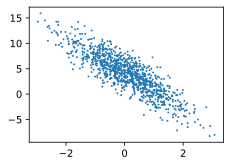

In [6]:
d2l.set_figsize()
# detach这个方法的作用是计算一个新tensor，指向原tensor但requires_grad被恒定置为false
# 这里scatter的输入是x,y,size
# size是点的size，默认20，这里设置为1（可以改为s=1)
# 回归程序本身，这里定义模型的时候输入是二维的，输出是一维的
# 这里按理应该输出一个二元函数的面图
# 但是这里取了二元函数的其中一元（第二维）作为横坐标，然后让label作为纵坐标，所以画出来的是一个一维的图
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1)
# 有一说一这里是否将tensor detach对画图没有什么影响。
# 
# d2l.plt.scatter(features[:,(1)].numpy(),labels.numpy(),1)


因为这次linearRegression是基础，所以这次并不使用torch库里的成型函数，而是都自己写
然后当数据集很大的时候，没法每次update都调用全部的数据集，所以有了**batch/minibatch**的概念
核心是每次提取一部分的样本和其对应的labels,然后提取的时候会将样本打乱。
在下⾯的代码中，我们定义⼀个data_iter函数，该函数接收批量⼤⼩、特征矩阵和标签向量作为输⼊，⽣成⼤⼩为batch_size的⼩批量。


In [7]:
def data_iter(batch_size,features,labels):
    # 输入样本的数量
    num_examples = len(features)
    # 给训练集输入的样本进行编号
    indices = list(range(num_examples))
    # 将样本编号进行shuffle，就说明对样本打乱
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        # 然后这里对所有的样本进行batch化
        # 具体的实现是直接进行切片
        # i的遍历方式是从0到num_examples，以batch_size为步长进行遍历
        # 然后索引i：i+batch_size,如果num_examples不能整除batch_size的话，最后一个batch就剩多少取多少
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]


        ## 上面那个函数里面最后的yield是啥意思？
        这里1000个样本 batch_size是10，理论上需要返还100个batch
        可以直接返回一个size为100的batch，但是如果我是希望在for循环里，调用一次这个函数，然后每轮循环都能让函数返还给我当次的batch
        对于这种需求，yield关键字可以发挥作用
        函数中写好for循环，并用yield设置好每一轮的返回值
        然后再主函数中就可以再for循环的条件里面(for xx in xx:)写上这个函数就能实现此功能。
        参考文献：https://blog.csdn.net/weixin_32148861/article/details/114913220

In [10]:
batch_size=10

for X,y in data_iter(batch_size,features,labels):
    # data_iter 可以根据输入的样本集和batch_size返回一整个for循环的batch
    print(X,'\n',y)# 然后这里对每一个batch进行print
    break# 但是为了输出可观，仅print一次就进行了循环的break

tensor([[-0.5998,  0.4632],
        [ 0.2566,  1.1904],
        [ 0.3029,  0.2512],
        [-0.3535,  2.5017],
        [ 0.4733,  1.0662],
        [-0.6928,  0.4277],
        [ 0.3128,  1.4577],
        [ 0.9175,  0.8702],
        [ 0.8196, -0.8512],
        [-0.6298, -0.5769]]) 
 tensor([[ 1.4102],
        [ 0.6696],
        [ 3.9470],
        [-5.0189],
        [ 1.5207],
        [ 1.3621],
        [-0.1161],
        [ 3.0829],
        [ 8.7368],
        [ 4.8944]])


In [45]:
# 初始化模型参数
# w是一个2x1的列向量，b是标量
# 然后w的两个元素初始化的的时候给了一个0~0.01之间的随机数，b直接给的0。然后两个参数都使能了梯度
w = torch.normal(mean=0.,std=0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [46]:
# funtion set定义
def linreg(X,w,b):
    # 定义function set，给定w，b和training set的dataset X,输出Regression的y_hat
    return torch.matmul(X,w)+b # 注意，这里w是列向量，X则以每一行为一个样本，所以是Xw+b

In [51]:
# loss function定义
def squared_loss(y_hat,y):
    """定义loss函数，这里以均方损失为loss"""
    # TODO 这里为啥是除以2呢？二范数？
    # 这里书上的代码特意把y reshape了一遍，这里确认一下shape是否有不一样
    # print(y_hat.shape,y.shape)# 事实证明，一样的
    # 注意，这里loss function传入的可能是一个batch的y和y_hat，在返回loss值的时候，并没有直接做summation，而是按照原始的格式return的
    return(y_hat-y.reshape(y_hat.shape)) ** 2 / 2# 其实，这里reshape的目的主要是防止万一shape不一样，python解释器调用广播机制然后出现计算失误

In [48]:
# 定义optimization，这里直接引入batch化的gradient descent
def sgd(params,lr,batch_size):
    """小批量随机梯度下降, small batch gradient descent"""
    with torch.no_grad():
    # 上面这一句声明表示在这个域下的所有计算不需要反向传播
    # 确实，这里是利用梯度做事情，不应该对梯度本身有任何影响。
    # 但是后面zero_()是手动清空的梯度，并不冲突
        for param in params:
            # 这里就是gradient descent的具体更新参数过程
            # 这里param就对应模型的某一个参数，然后因为要loss最低，所以要逆梯度方向
            # 然后乘一个系数lr，这个意思是learning rate
            # 然后因为是batch化更新，所以除一个batch_size
            param -= lr * param.grad/batch_size
            # 梯度使用完毕，避免累积所以调用zero_()函数进行清空
            param.grad.zero_()

In [49]:
# 机器学习三大块：function set/loss function/optimizer/已经聚齐了，就可以进行训练了
# 这里先设定一系列超参数，这个部分是自己手动设置的，调参主要调的也是这部分的内容
lr = 0.03# 学习率，决定梯度对于参数的更新力度
num_epochs = 3# 迭代次数，因为batch化了，所以把所有的batch过一遍叫一次epoch，一共迭代几个轮，有这个参数决定
net = linreg # function set
loss = squared_loss # loss function

In [50]:
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y)
        # 因为loss函数返回的是一列loss（即每一个data的loss），所以还需要做一下summation
        l.sum().backward()#l.sum是计算total loss，.backward是进行反向传播计算各个参数的梯度
        sgd([w,b],lr,batch_size)# 一共有w和b两种参数，全部进行gradient descent
    # 迭代完一个epoch之后打印一下每一轮的训练结果
    with torch.no_grad():# 以下操作不影响梯度
        train_l= loss(net(features,w,b),labels)# 对更新完参数之后的model计算一个loss
        print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')# 这里输出的loss是data points的单点平均loss

epoch1,loss0.050027
epoch2,loss0.000213
epoch3,loss0.000053


In [52]:
# 输出训练后的参数与真实参数的误差
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：tensor([ 0.0011, -0.0009], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0006], grad_fn=<RsubBackward1>)
